<a href="https://colab.research.google.com/github/sab747/adaboost/blob/main/adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdaBoost Implementation

Implementation of AdaBoost from scratch and 10 fold cross-validation with and without AdaBoost on three base classifiers (Gaussian NB, Decision Tree and Linear SVM)

Author: Sabrina Jain   

Professor VS Subrahmanian    

CS 74, Fall 2020  

7 November 2020

## Import

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import json
import random
import numpy as np
import copy
import statistics 
from collections import Counter

# sklearn library
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

## Functions

In [ ]:
"""
cross_val_ada_boost

Custom cross validation function with the ability to cross validate a boosted
classifier using AdaBoost (ada_boost_on=True). Also can scale data (scaled=True)
"""
def cross_val_ada_boost (data,base_model,ada_boost_on=False,scaled=False):
  f1_scores = []
  skf = KFold(n_splits=10) # 10 splits
  for train_index, test_index in skf.split(data.drop(labels="RainTomorrow",axis=1),data['RainTomorrow']): # iterate through each split
    train, test = data.iloc[train_index], data.iloc[test_index] # note: not split into X and y right now because of AdaBoost
    if scaled: # if scaling data
      x = train.values
      x_test = test.values
      sc = MinMaxScaler()
      x_scaled = sc.fit_transform(x)
      x_test_scaled = sc.transform(x_test)
      train = pd.DataFrame(x_scaled, columns=train.columns, index=train.index) # put back into dataframe
      train['RainTomorrow'].replace(0,-1,inplace=True)
      test = pd.DataFrame(x_test_scaled, columns=test.columns, index=test.index) # put back into dataframe
      test['RainTomorrow'].replace(0,-1,inplace=True)
    if ada_boost_on: # if using Ada Boost
      models = ada_boost(train,base_model)
      f1_weighted = predict_ada_boost(test,models) # generate predictions and get f1
    else: # if only using base classifier
      X_train = train.drop(labels="RainTomorrow",axis=1)
      X_test = test.drop(labels='RainTomorrow',axis=1)
      y_train = train['RainTomorrow']
      base_model.fit(X_train, y_train) # fit model
      predictions = base_model.predict(X_test) # generate predictions
      truth = test['RainTomorrow'].to_numpy() # get ground truth
      f1_weighted = f1_score(truth, predictions, average="weighted") # get f1
    f1_scores.append(f1_weighted)
  f1_scores = np.array(f1_scores)
  print("F1 weighted: %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std() * 2)) # report mean f1 and standard deviation

"""
final_training()

Generate final predictions files for each model
"""
def final_training(train,test,base_model,filename,ada_boost_on=False,scaled=False):
  if scaled: # if scaling data
      x_train = train.drop(labels="RainTomorrow", axis = 1)
      x = x_train.values
      x_test = test.values
      sc = MinMaxScaler()
      x_scaled = sc.fit_transform(x)
      x_test_scaled = sc.transform(x_test)
      train = pd.DataFrame(x_scaled, columns=x_train.columns, index=x_train.index).join(train["RainTomorrow"])
      train['RainTomorrow'].replace(0,-1,inplace=True)
      test = pd.DataFrame(x_test_scaled, columns=test.columns, index=test.index) 
  if ada_boost_on: # if using ada boost
      models = ada_boost(train,base_model)
      generate_ada_boost_predictions(test,models,filename) # generate predictions and write to csv
  else:
    X_train = train.drop(labels="RainTomorrow",axis=1)
    X_test = test # no RainTomorrow column
    y_train = train['RainTomorrow']
    base_model.fit(X_train, y_train)
    predictions = base_model.predict(X_test)
    c = Counter(predictions) # sanity check
    print(c)
    pred_table = pd.DataFrame(predictions)
    pred_table.to_csv(filename, index=True) # write predictions to csv


"""
ada_boost()

Implementation of the Ada Boost method from scratch. Utilizes the 
sample_weight parameter in the .fit function of the 3 sklearn classifiers
used in this notebook to train each classifier on a weighted distribution
"""
def ada_boost (data, base_model, T=50):
  data = data.reset_index(drop=True) # make sure index starts at zero
  weights = []
  model_arr = [] # will hold individual classifiers
  for index, row in data.iterrows(): # initialize weights to be the same
    weights.append(1/data.shape[0])
  for j in range(T): # iterate through T times
    model = copy.deepcopy(base_model) 
    model.fit(data.drop(labels=['RainTomorrow'],axis=1),data['RainTomorrow'],sample_weight=weights) # train model on weighted distribution
    predictions = model.predict(data.drop(labels=['RainTomorrow'],axis=1)) # make predictions on all training data
    error = 0
    for i, row in data.iterrows(): # go through every row
      if predictions[i] != data.iloc[i]['RainTomorrow']: # if prediction is wrong
        error += weights[i] # add weight to error term
    error = error / sum(weights) # divide error by the sum of weights
    accuracy = math.log((1-error)/error)/2 # accuacy term
    z = 0
    for r in range(len(predictions)): # calculate z constant
        z += weights[r] * math.exp((-1 * accuracy) * data.iloc[r]['RainTomorrow'] * predictions[r])
    for i in range(len(predictions)): # update weights
        weights[i] = (weights[i] * math.exp((-1 * accuracy) * data.iloc[i]['RainTomorrow'] * predictions[i])) / z
    model_arr.append((model,accuracy)) # add classifier + its weight (accuracy)
  return model_arr # return classifiers


"""
predict_ada_boost()

Generate predictions based on array of weighted classifiers 
returned by ada boost
"""
def predict_ada_boost (test, model_arr):
  predictions = [] # list of predictions for each classifier
  for i in range(len(model_arr)): # go through all classifiers
    pred = model_arr[i][0].predict(test.drop(labels="RainTomorrow", axis=1)) # make predictions
    pred = np.where(pred==0, -1, pred) # replace 0s in predictions with -1
    pred = pred * model_arr[i][1] # weight by accuracy
    predictions.append(pred) # add to list of predictions
  final_pred = predictions[0] # will hold combined predictions
  for i in range(1, len(predictions)): # add all predictions together
    final_pred = np.add(final_pred,predictions[i])
  truth = test['RainTomorrow'].to_numpy() # get ground truth
  return f1_score(truth,np.sign(final_pred),average="weighted")

"""
generate_ada_boost_predictions()

Generate predictions for final test set based on weighted classifiers
return by ada boost and write predictions to as csv file.
"""
def generate_ada_boost_predictions (test, model_arr, filename):
  predictions = [] # list of predictions for each classifier
  for i in range(len(model_arr)): # go through all classifiers
    pred = model_arr[i][0].predict(test) # make predictions
    pred = np.where(pred==0, -1, pred) # replace 0s in predictions with -1
    pred = pred * model_arr[i][1] # weight by accuracy
    predictions.append(pred) # add to list of predictions
  final_pred = predictions[0] # will hold combined predictions
  for i in range(1, len(predictions)): # add all predictions together
    final_pred = np.add(final_pred,predictions[i])
  c = Counter(np.sign(final_pred)) # sanity check
  print(c)
  pred_table = pd.DataFrame(np.sign(final_pred))
  pred_table.to_csv(filename, index=True) # write predictions to csv file

## Import/Format Data

In [ ]:
"""
make_numerical()

Loads dataset and makes dependent variable (RainTomorrow) and
and RainToday numerical values
"""
def make_numerical (filename, test=False):
  weather_data = pd.read_csv(filename) # read data
  weather_data.replace(('Yes', 'No'), (1, 0), inplace=True) # make all Yes/No values 1 and 0
  #weather_data = weather_data.dropna() # decided not to drop samples
  if test: # if test data, drop the empty RainTomorrow column (filled with NaN)
    weather_data = weather_data.drop(labels='RainTomorrow', axis=1)
  else: # otherwise, replace 0s in RainTomorrow column with -1
    weather_data['RainTomorrow'].replace(0,-1,inplace=True)
  return weather_data

"""
winddir_to_numerical()

Option to make wind directions numerical
"""
def to_numerical (data):
  data.WindDir9am = pd.Categorical(data.WindDir9am)
  data['WindDir9am'] = data.WindDir9am.cat.codes
  data.WindDir3pm = pd.Categorical(data.WindDir3pm)
  data['WindDir3pm'] = data.WindDir3pm.cat.codes
  data.WindDir9am.replace(-1,0,inplace=True)
  data.WindDir3pm.replace(-1,0,inplace=True)
  return data

"""
one_hot_encode_winddir()

One hot encode used wind directions (note: didn't end up using
in final feature set)
"""
def one_hot_encode_winddir (data):
  one_hot = pd.get_dummies(data['WindDir9am']) # get dummy variables
  data_oh = data.drop(labels='WindDir9am',axis = 1) # drop column
  data_oh = data_oh.join(one_hot) # put one-hot columns into dataframe
  one_hot = pd.get_dummies(data['WindDir3pm']) # get dummy variables 
  data_oh = data_oh.drop(labels='WindDir3pm',axis = 1) # drop column
  data_oh = data_oh.join(one_hot,lsuffix="3pm") # put one-hot columns into dataframe
  return data_oh

In [ ]:
train_data = make_numerical('Weather.csv')
test_data = make_numerical('weather_test.csv', test=True)

## Feature Selection

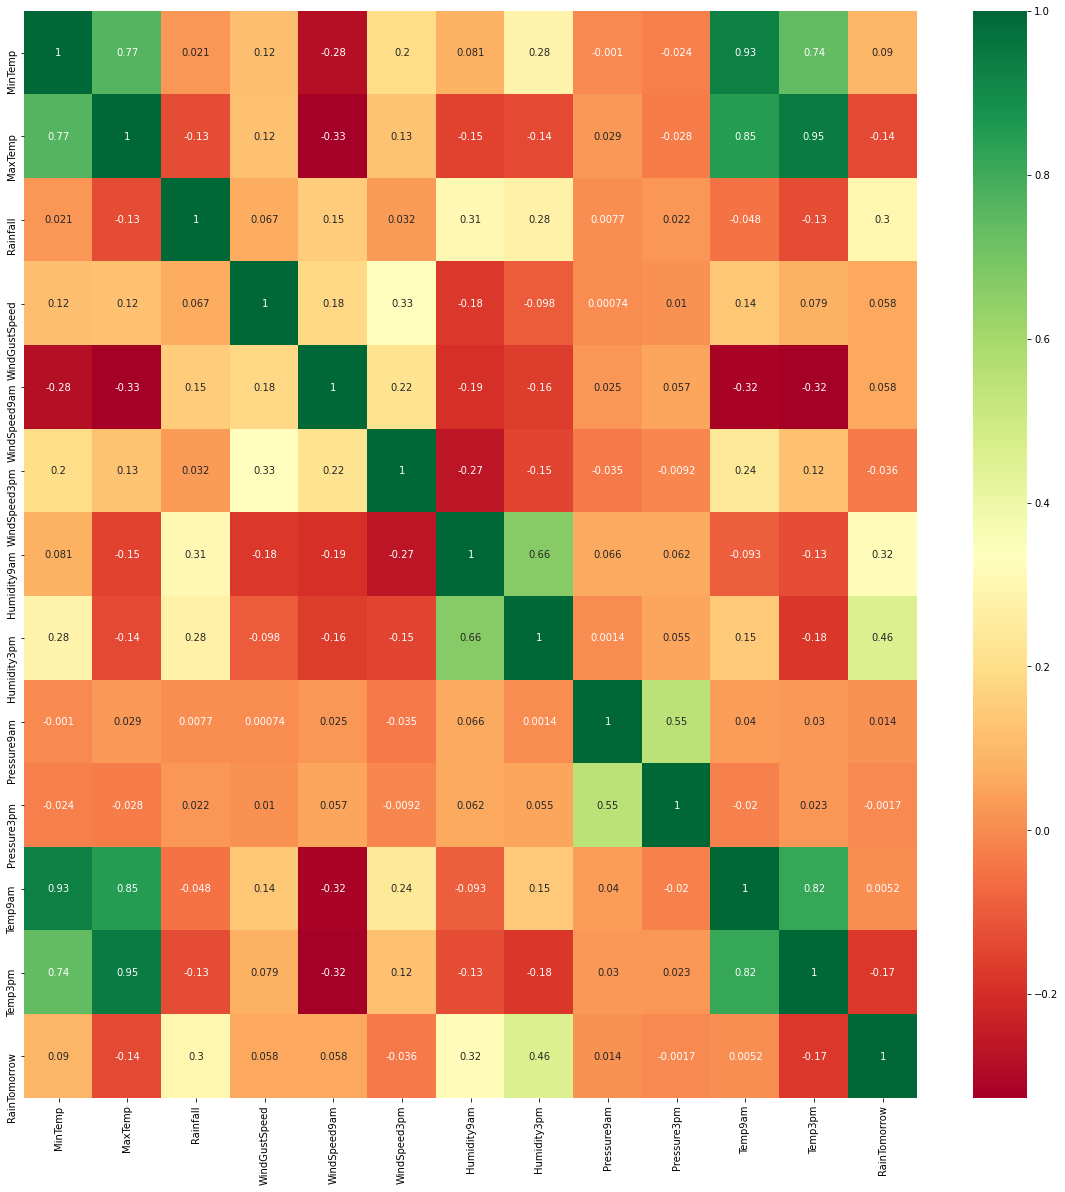

In [ ]:
import seaborn as sns

corrmat = train_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
#Based on the heat map above, I will remove ['Temp9am', 'Temp3pm',
#'WindGustDir', 'Min Temp', 'Pressure3pm','Humidity9am']
train_data = train_data.drop(labels=['Temp9am','Pressure3pm','Temp3pm','MinTemp','WindGustDir','Humidity9am'], axis = 1)
test_data = test_data.drop(labels=['Temp9am','Pressure3pm','Temp3pm','MinTemp','WindGustDir','Humidity9am'], axis = 1)

# One hot encode Wind directions (Note: didn't end up using this dataset)
train_oh = one_hot_encode_winddir(train_data)
test_oh = one_hot_encode_winddir(test_data)

# Make wind directions numerical (instead of one-hot encoding)
train_data = to_numerical(train_data)
test_data = to_numerical(test_data)

## Cross-Validation of Classifiers (w/ and w/o boosting)

### Naive Bayes

In [ ]:
cross_val_ada_boost(train_data,GaussianNB(),ada_boost_on=False)

F1 weighted: 0.7974 (+/- 0.0505)


In [ ]:
cross_val_ada_boost(train_data,GaussianNB(),ada_boost_on=True)

F1 weighted: 0.8143 (+/- 0.0507)


### Decision Tree

In [ ]:
cross_val_ada_boost(train_data,DecisionTreeClassifier(max_depth=7,max_features=6,max_leaf_nodes=6),ada_boost_on=False)

F1 weighted: 0.8045 (+/- 0.0557)


In [ ]:
cross_val_ada_boost(train_data,DecisionTreeClassifier(max_depth=7,max_features=6,max_leaf_nodes=6),ada_boost_on=True)

F1 weighted: 0.8174 (+/- 0.0517)


### LinearSVC

In [ ]:
cross_val_ada_boost(train_data,LinearSVC(C=10, max_iter=3000),ada_boost_on=False,scaled=True)

F1 weighted: 0.8145 (+/- 0.0491)


In [ ]:
cross_val_ada_boost(train_data,LinearSVC(C=10, max_iter=3000),ada_boost_on=True,scaled=True)

F1 weighted: 0.8028 (+/- 0.0527)


## Final Training + Predictions on Test Data

In [ ]:
# Naive Bayes predictions
final_training(train_data,test_data,GaussianNB(),'NB_base_predictions.csv')
final_training(train_data,test_data,GaussianNB(),'NB_Ada_predictions.csv',ada_boost_on=True)

Counter({-1: 664, 1: 173})
Counter({-1.0: 623, 1.0: 214})


In [ ]:
# Decision Tree predictions
final_training(train_data,test_data,DecisionTreeClassifier(max_depth=7,max_features=6,max_leaf_nodes=6),'DT_base_predictions.csv')
final_training(train_data,test_data,DecisionTreeClassifier(max_depth=7,max_features=6,max_leaf_nodes=6),'DT_Ada_predictions.csv', ada_boost_on=True)

Counter({-1: 657, 1: 180})
Counter({-1.0: 673, 1.0: 164})


In [ ]:
# Linear SVM predictions
final_training(train_data,test_data,LinearSVC(C=10, max_iter=3000),'LSVM_base_predictions.csv',scaled=True)
final_training(train_data,test_data,LinearSVC(C=10, max_iter=3000),'LSVM_Ada_predictions.csv',ada_boost_on=True,scaled=True)

Counter({-1: 703, 1: 134})
Counter({-1.0: 652, 1.0: 185})
